In [1]:
library(dplyr)
library(lme4)
library(nlme)
library(purrr)
library(performance)
library(tibble)
library(MuMIn)
library(here)
library(reactablefmtr)
library(emmeans)
library(car)
library(ggplot2)
library(modelr)
require(vegan)
require(knitr)
require(ggpubr)
library(ggeffects)
library(janitor)
library(factoextra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘nlme’


The following object is masked from ‘package:lme4’:

    lmList


The following object is masked from ‘package:dplyr’:

    collapse


here() starts at /home/ecamo19/Documents/projects/nutrients_and_water_effects_2022/shade_house_reproducible_stats

Loading required package: reactable

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:purrr’:

    some


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘ggplot2’


The following object is masked from ‘package:reactablefmtr’:

    margin



Attaching package: ‘modelr’


The following objects are masked from ‘package:performance’:

    mae, mse, rmse


Loading required package: vegan



In [2]:
setwd(here::here())

In [3]:
# Load all joined dataset
source("./scripts/code_join_data_full_dataset.R")


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [4]:
# Load custom made functions
source("./R/functions_models.R")
source("./R/function_plots.R")
source("./R/function_validation_plots.R")
source("./R/function_for_inference_emmeans_and_percentage_diff.R")


In [5]:
# set plot dimensions
options(repr.plot.width = 15)
options(repr.plot.height = 10)

__For running each peice of code press shift + Enter__

# __Q3:How do functional traits, treatment, and N-fixing status interact to influence seedling-level growth rates and biomass accumulation?__


## PCA


In [6]:
# Select variables that are going to be used in the model
data_for_models <-
    data_for_models %>%

    clean_names() %>%
    # Select columns needed for regression
    dplyr::select(spcode, treatment, nfixer, init_height,

                  # Performance measures
                  total_biomass, rgr, root_shoot_ratio,

                  # physiology traits
                  amax, gs, wue,

                  # Leaf traits
                  narea_g_m2, d13c, sla) %>%
    clean_names()

In [7]:
# Scale and center traits
data_traits_scaled <-
    data_for_models %>%
        select(-c(total_biomass, rgr, root_shoot_ratio, init_height)) %>%
        mutate(across(where(is.numeric), scale))

In [8]:
pca_traits <- princomp(data_traits_scaled[,c(4:ncol(data_traits_scaled))])

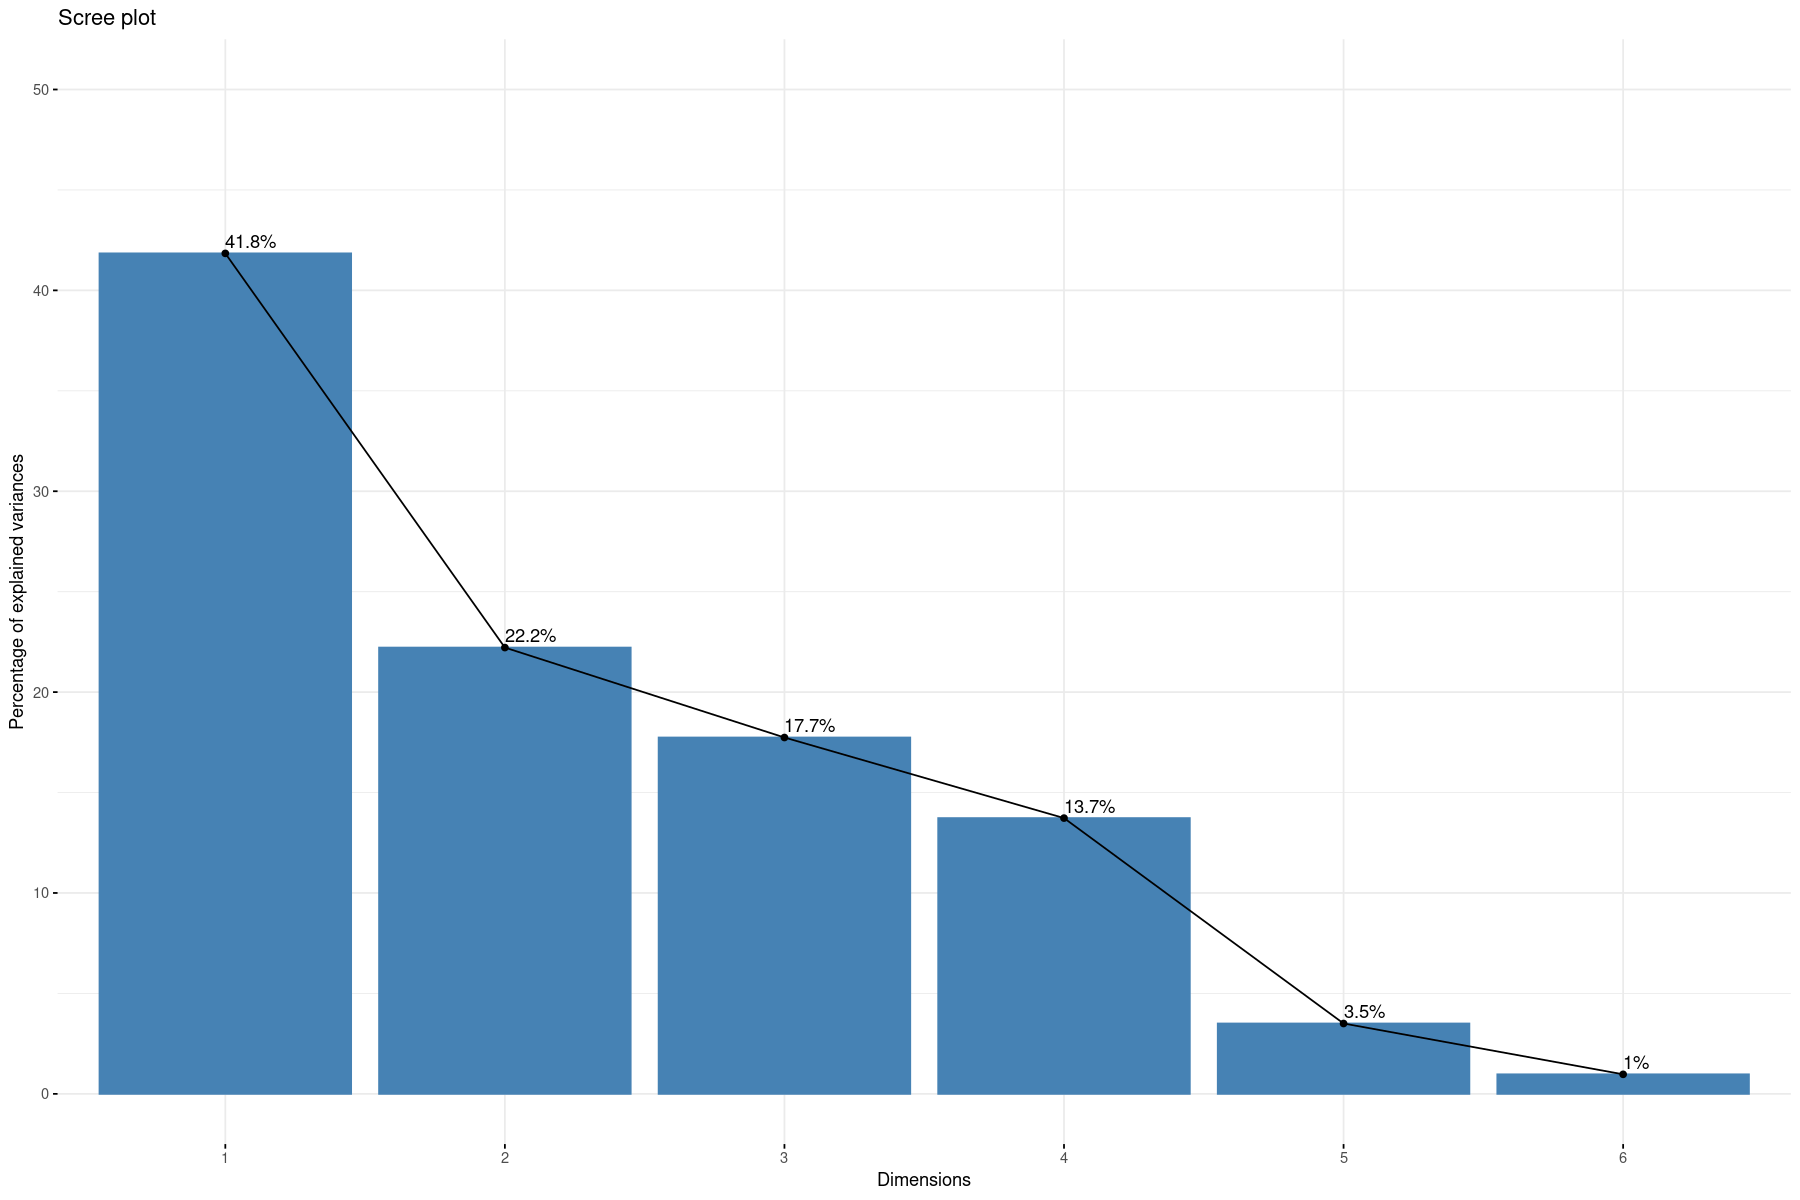

In [213]:
fviz_screeplot(pca_traits, addlabels = TRUE, ylim = c(0, 50))

In [9]:
# Extract loadings
pca_traits$loadings


Loadings:
           Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
amax        0.601  0.109  0.198         0.107  0.759
gs          0.169  0.718  0.287  0.391  0.301 -0.360
wue         0.475 -0.474  0.117 -0.231  0.558 -0.414
narea_g_m2  0.583               -0.129 -0.711 -0.349
d13c        0.199 -0.239 -0.588  0.743              
sla               -0.426  0.714  0.474 -0.278       

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.167  0.167  0.167  0.167  0.167  0.167
Cumulative Var  0.167  0.333  0.500  0.667  0.833  1.000

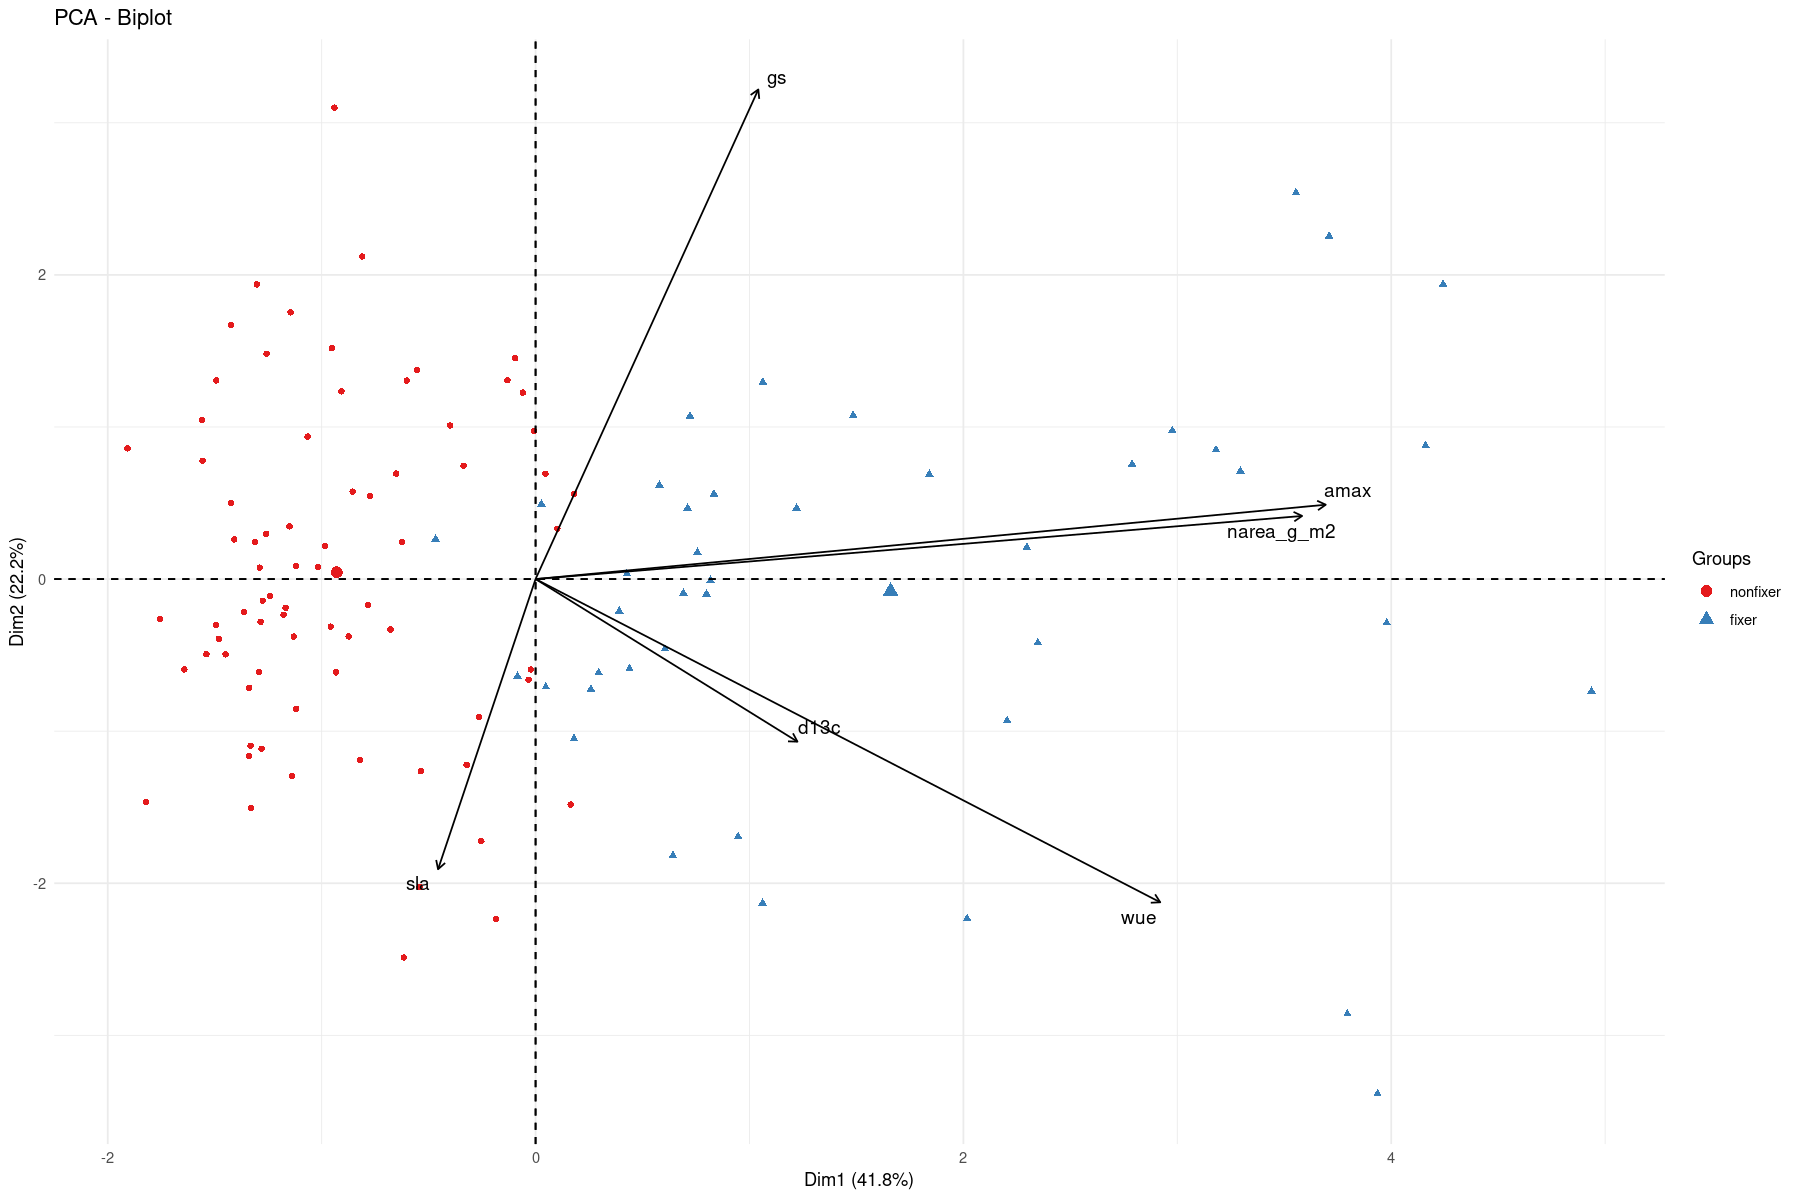

In [10]:
fviz_pca_biplot(pca_traits,axes = c(1, 2),

                # Add group
                habillage= data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

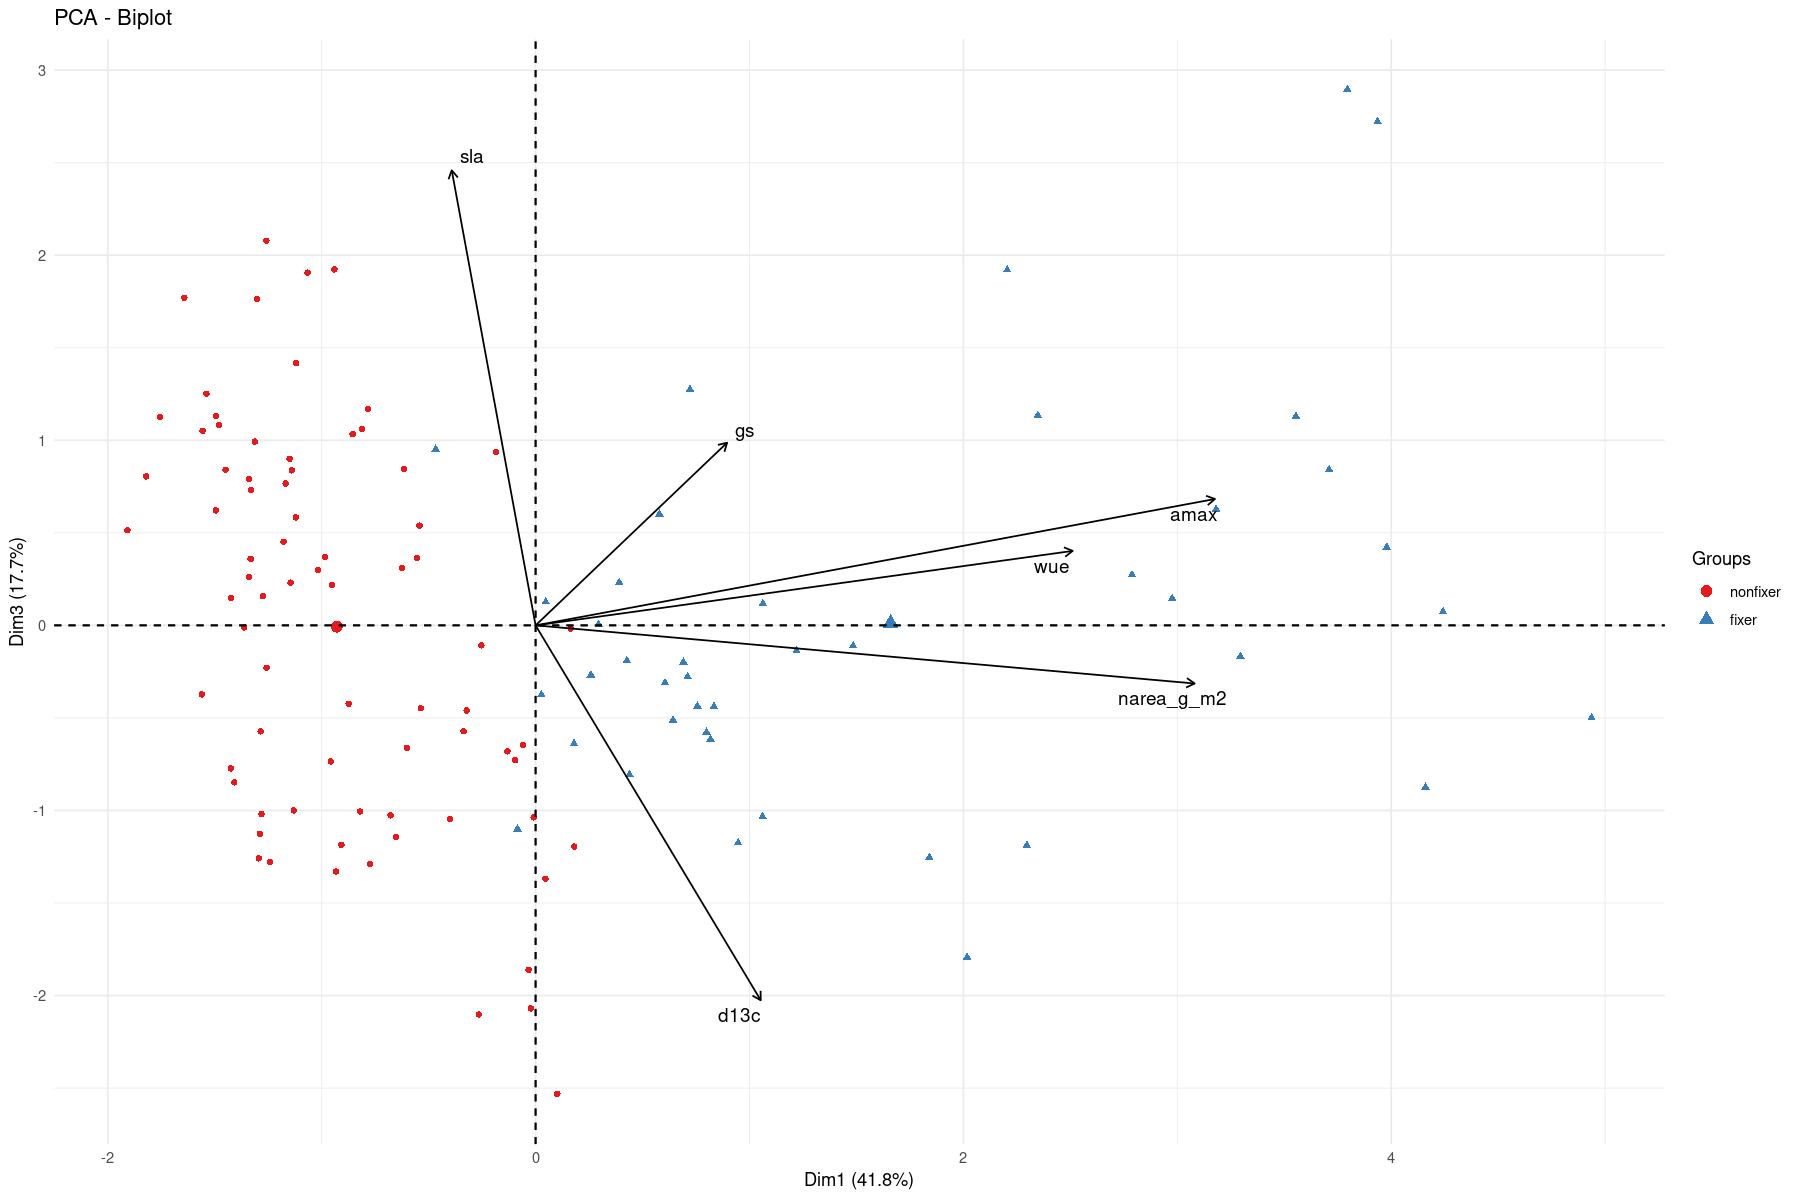

In [11]:
fviz_pca_biplot(pca_traits,axes = c(1, 3),

                # Add group
                habillage = data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

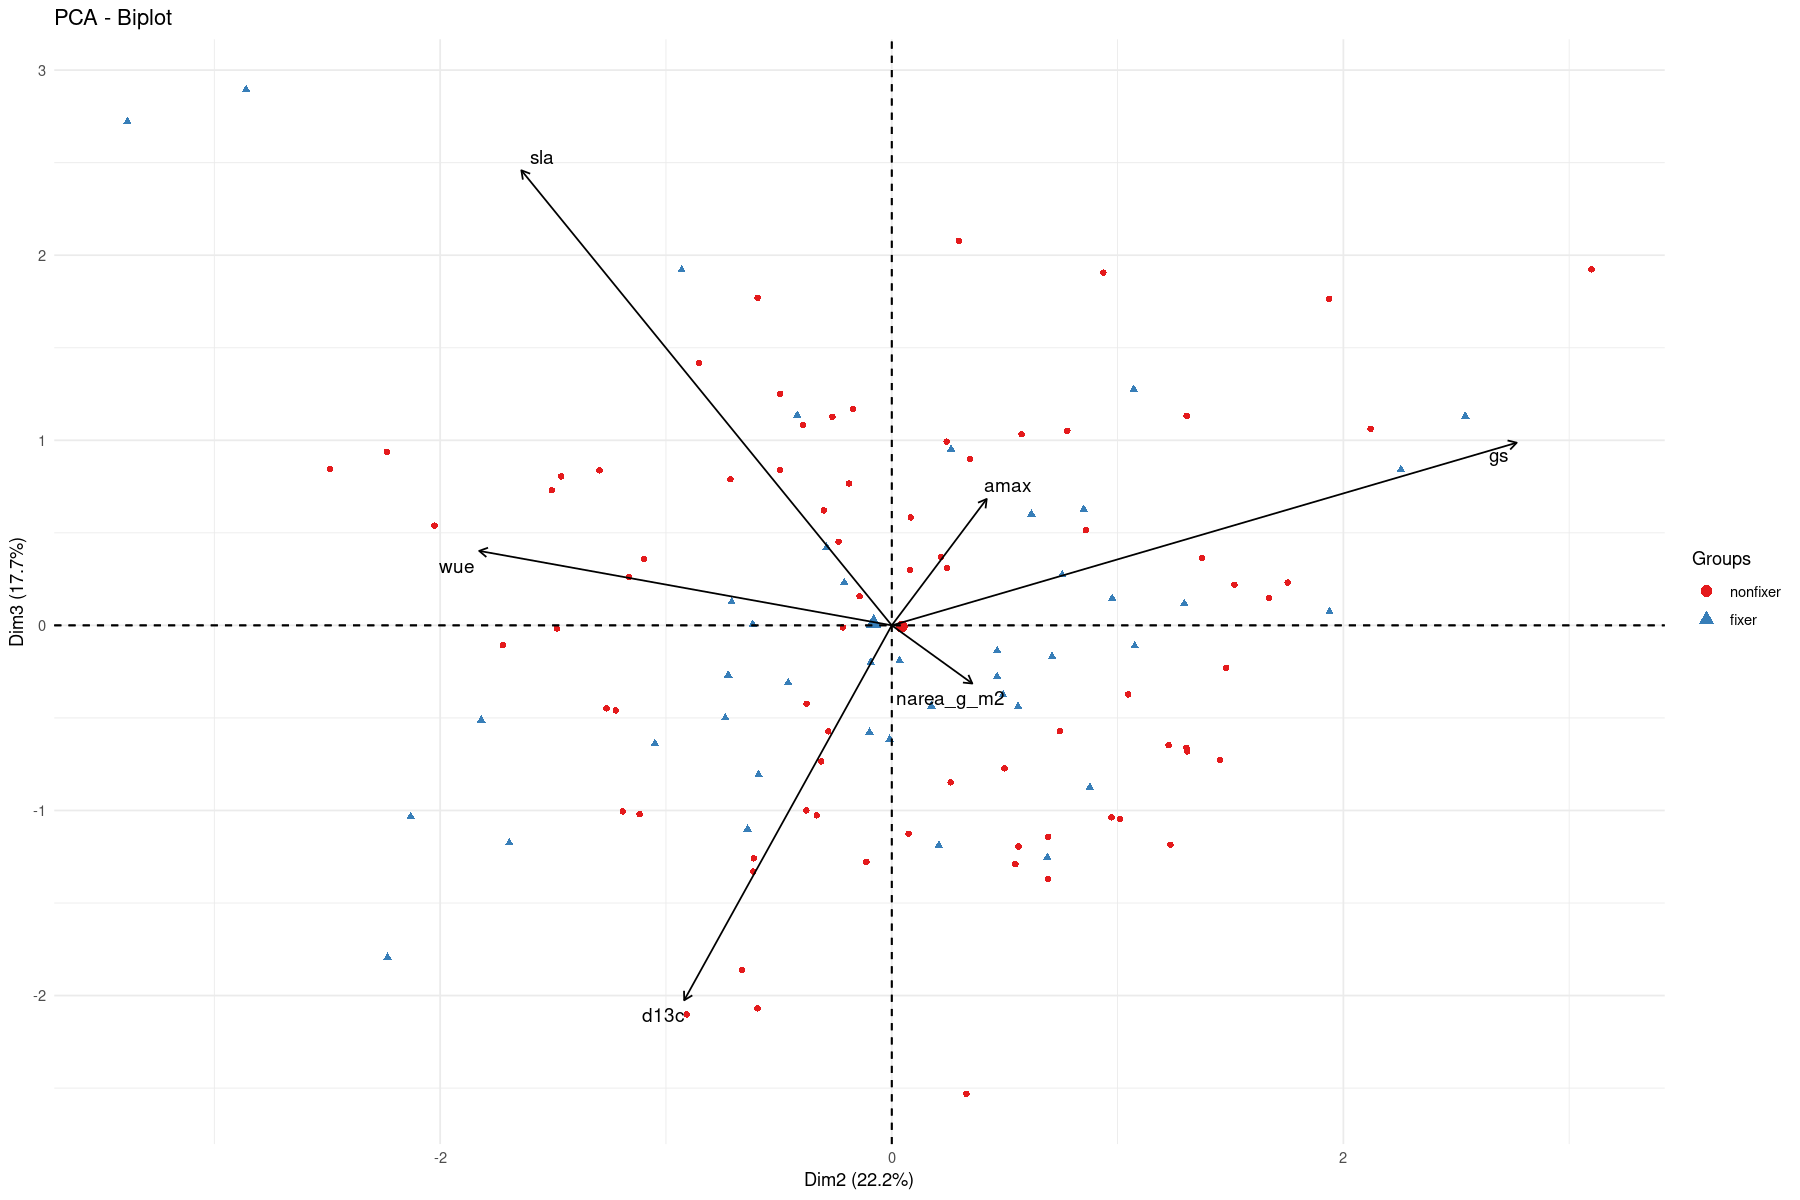

In [12]:
fviz_pca_biplot(pca_traits,axes = c(2, 3),

                # Add group
                habillage = data_traits_scaled$nfixer,

                # Set labels
                label ="var",

                # Set arrow color
                col.var = "black",

                # Repel overlapping labels
                repel = TRUE) +
  theme_minimal() + scale_color_brewer(palette="Set1")

## Biplots interpretation
[PCA interpretation](https://wilkelab.org/SDS375/slides/dimension-reduction-1.html#18)

+ The first 3 PCs explains 81% (47.9,19.4,15.8) of the variability in the data
+ PC1 separates fixers from non-fixers
+ All traits contribute positively to PC1 

+ PC1 represents the overall high photosynthetic capacity 
+ PC2 represents the difference between stomatal conductance and SLA
+ PC3 represents the difference between d13c and SLA

## Regression model with PCs as independent variables

$$response\sim treatment*fixer*PCn\ + initial\ height\ + random(1|specie)$$

In [14]:
pca_scores <- scores(pca_traits)

In [15]:
# Extract PCs
data_traits_scaled$pc1 <- pca_scores[,1]
data_traits_scaled$pc2 <- pca_scores[,2]
data_traits_scaled$pc3 <- pca_scores[,3]


data_pcs <-
    data_traits_scaled %>%
    select(1:3, 10:12)

In [16]:
data_for_regression <-
    inner_join(data_for_models, data_pcs, , by = c("treatment","spcode", "nfixer")) %>%
    select(-c("amax", "gs",	"wue", "narea_g_m2", "d13c", "sla"))


Warning message in inner_join(data_for_models, data_pcs, , by = c("treatment", "spcode", :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [17]:
# add t-ratio
emm_options(contrast = list(infer = c(TRUE, TRUE)))

In [19]:
#model_pc_total_biomass <- lmer(total_biomass ~ treatment + nfixer+ pc1 + pc2 + pc3 +
#
#                            # Two way interactions
#                            # Treatments
#                            treatment * pc1 +
#                            treatment * pc2 +
#                            treatment * pc3 +
#
#                            # NFixer
#                            nfixer * pc1 +
#                            nfixer * pc2 +
#                            nfixer * pc3 +
#
#                            (1|spcode) +
#
#                            # Control over different plant heights
#                            init_height,
#
#                        data = data_for_regression)


In [74]:
model_pc_total_biomass <- lmer(total_biomass ~ treatment * nfixer * pc1 +
                                                treatment * nfixer * pc2 +
                                                treatment * nfixer * pc3 +
                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression)

In [95]:
# Scale and center traits


,spcode,treatment,nfixer,amax,gs,wue,narea_g_m2,d13c,sla
,<fct>,<fct>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
5,ec,no_additions,fixer,2.44092136,-0.40227003,5.04763147,0.58864050,-0.102721579,2.45818319
6,ec,no_additions,fixer,2.46203049,0.27166007,2.25284429,2.33374133,0.026113600,-0.25055174
7,ec,no_additions,fixer,2.09888483,-0.12427386,3.09968660,3.53894085,0.480014767,-0.89263442
8,ec,no_additions,fixer,2.48434095,-0.26748401,4.43014228,0.90197918,-0.505697894,2.44428534
9,ec,plus_water_nutrients,fixer,1.79735037,0.27166007,0.84040265,2.36778097,-0.877842929,-0.78354971
10,ec,plus_water_nutrients,fixer,2.18864153,0.35590133,1.07338806,0.70688331,0.326649619,2.12143299
11,ec,plus_water_nutrients,fixer,1.85621567,0.35590133,0.83417586,1.37646241,0.331528661,1.24250729
12,ec,plus_water_nutrients,fixer,2.29212775,0.54965624,1.02201711,3.40330588,0.629194894,-1.29601931
13,ec,plus_water,fixer,1.96673826,0.97086255,0.84351604,2.03836852,-0.026147709,-0.63155053


In [92]:
lmer(total_biomass ~ treatment * +
                        treatment *  +
                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression)

Linear mixed model fit by REML ['lmerMod']
Formula: total_biomass ~ treatment * +treatment * +(1 | spcode) + init_height
   Data: data_for_regression
REML criterion at convergence: 1853.095
Random effects:
 Groups   Name        Std.Dev.
 spcode   (Intercept) 3.180   
 Residual             1.943   
Number of obs: 435, groups:  spcode, 8
Fixed Effects:
                  (Intercept)        treatmentplus_nutrients  
                       4.0749                         3.0482  
          treatmentplus_water  treatmentplus_water_nutrients  
                       1.5234                         3.4084  
                  init_height  
                       0.1883  

In [20]:
model_pc_rgr <- lmer(rgr ~ treatment + nfixer+ pc1 + pc2 + pc3 +

                            # Two way interactions
                            # Treatments
                            treatment * pc1 +
                            treatment * pc2 +
                            treatment * pc3 +

                            # NFixer
                            nfixer * pc1 +
                            nfixer * pc2 +
                            nfixer * pc3 +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression)


In [21]:
model_pc_root_shoot <- lmer(root_shoot_ratio ~ treatment + nfixer+ pc1 + pc2 + pc3 +

                            # Two way interactions
                            # Treatments
                            treatment * pc1 +
                            treatment * pc2 +
                            treatment * pc3 +

                            # NFixer
                            nfixer * pc1 +
                            nfixer * pc2 +
                            nfixer * pc3 +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression)

## Model Assumptions

[1] "No variable specified inthe variables argument"


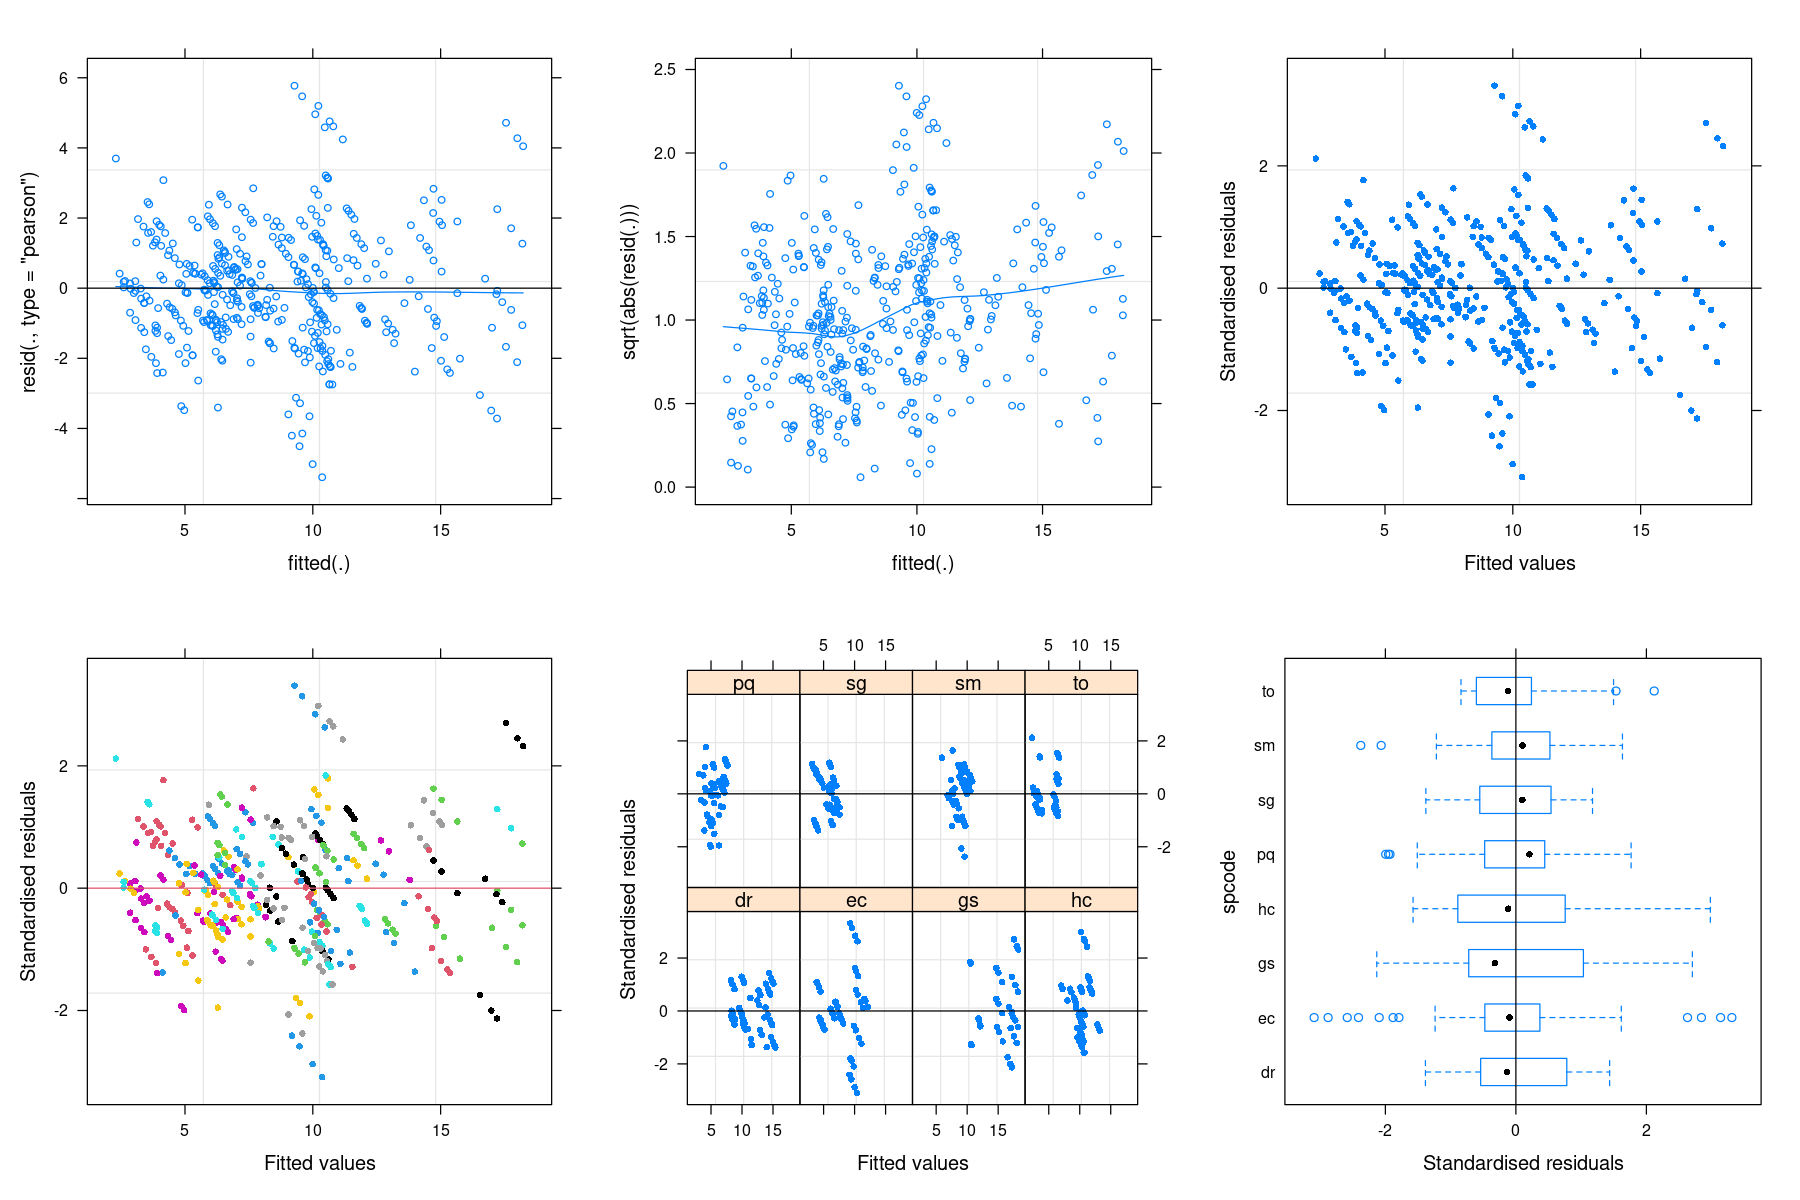

In [75]:
par(mfrow = c(3,3))
validation_plots(model_pc_total_biomass, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


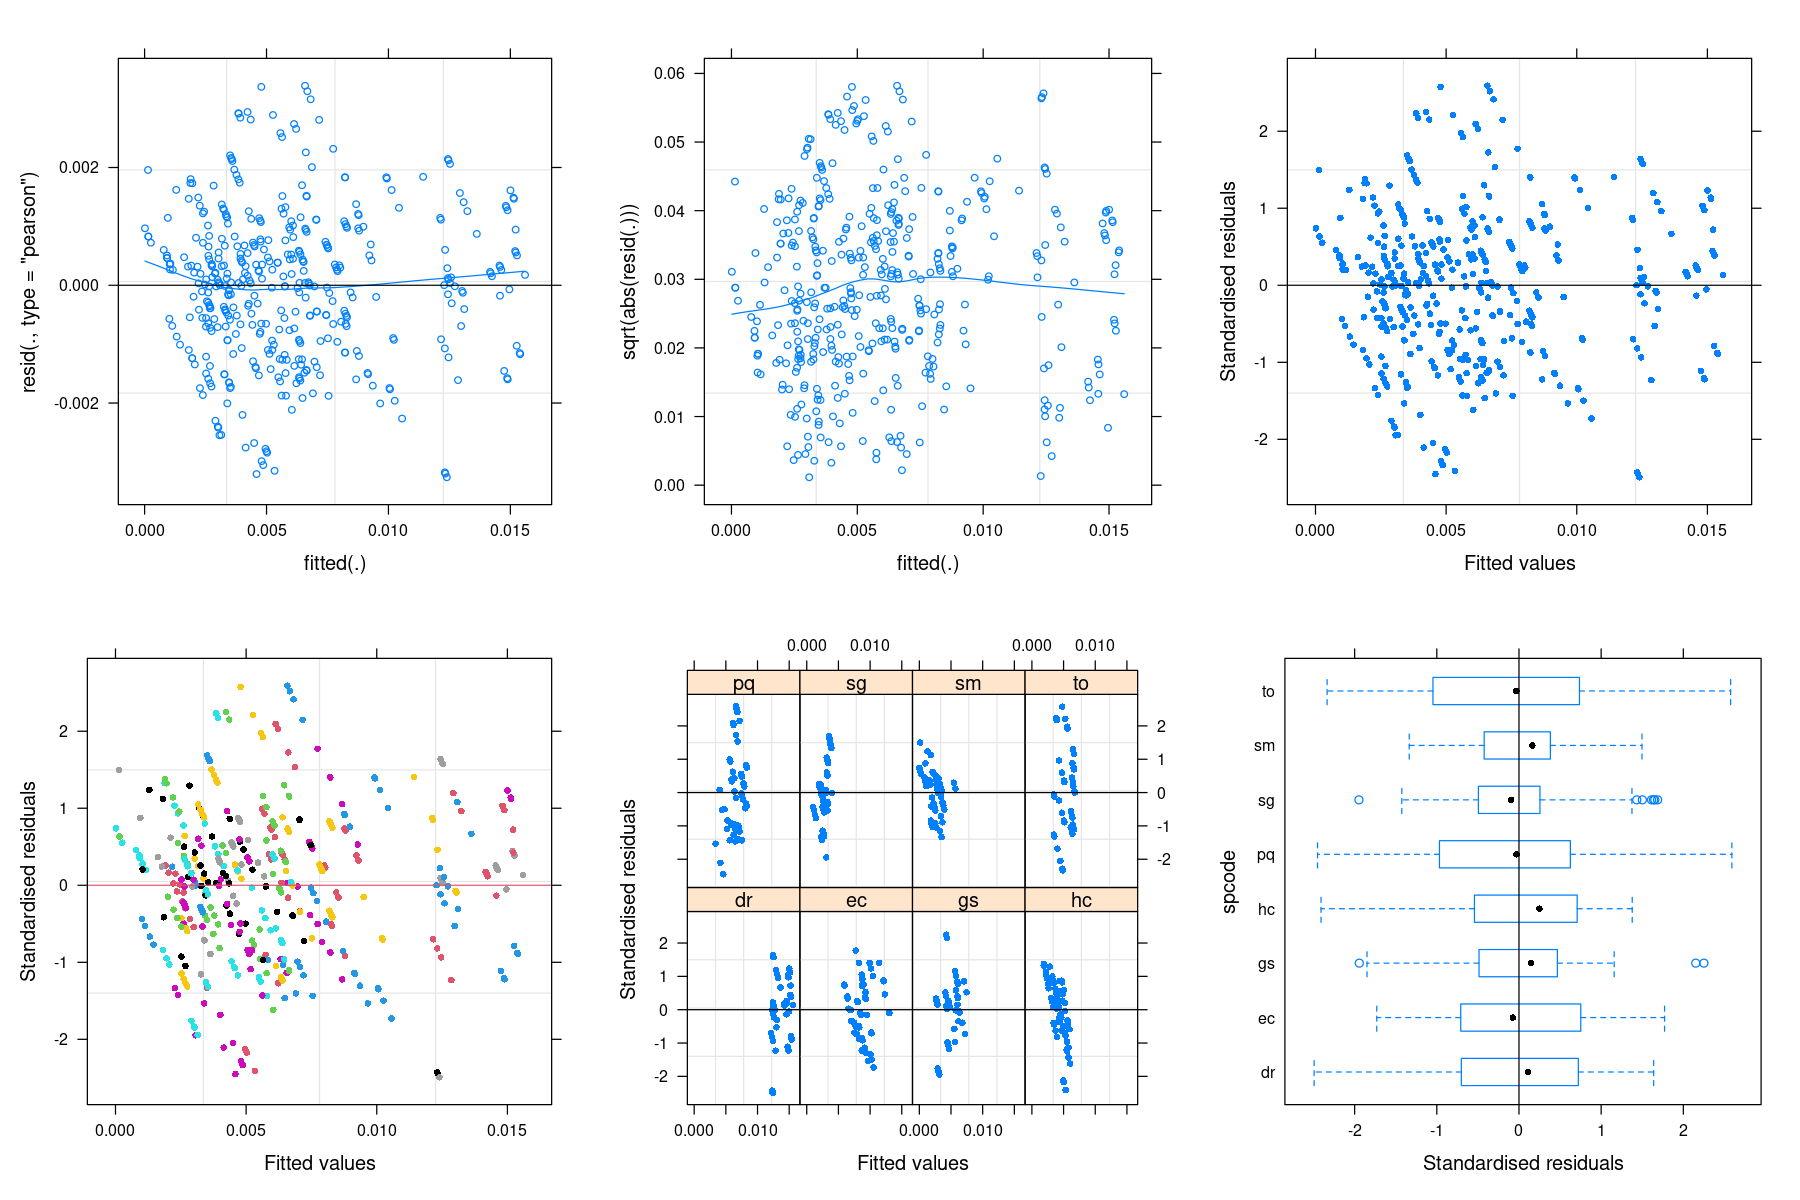

In [23]:
par(mfrow = c(3,3))
validation_plots(model_pc_rgr, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


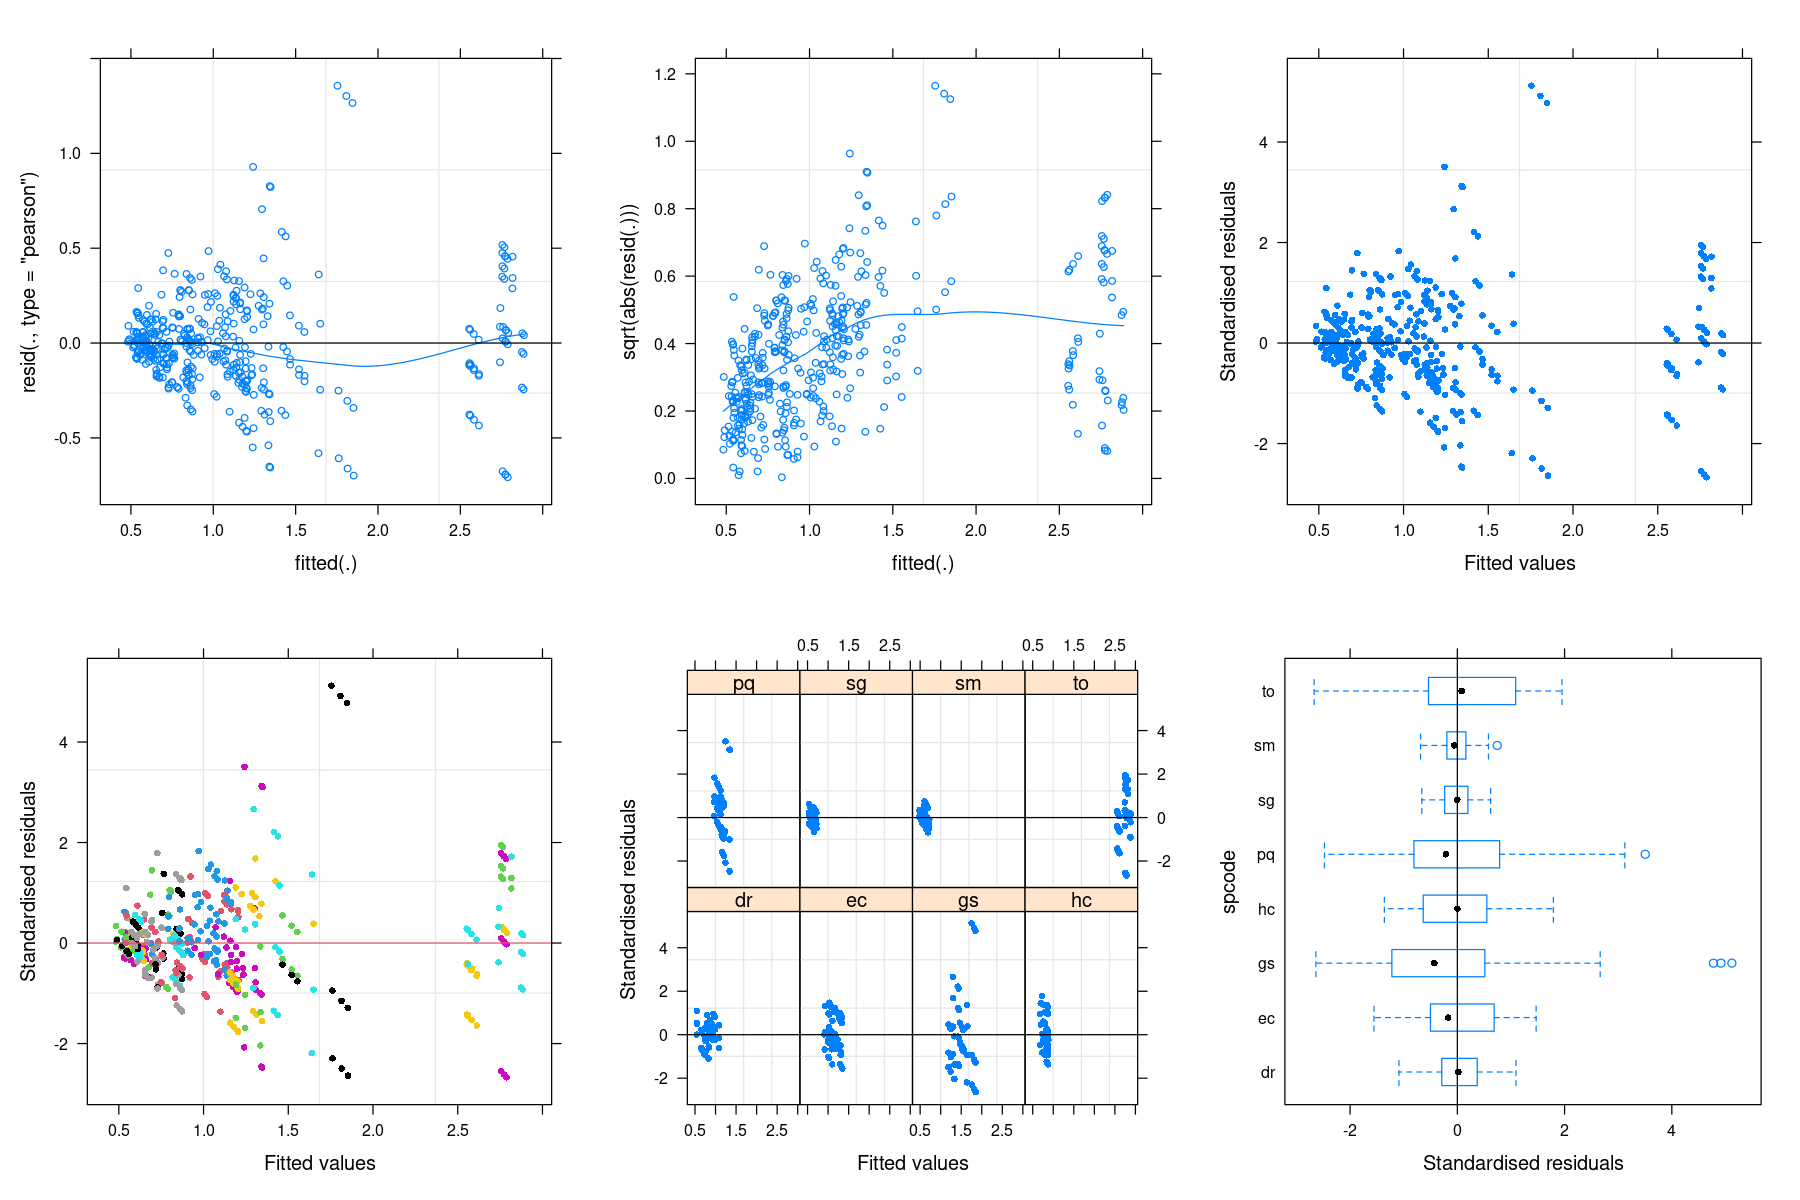

In [24]:
par(mfrow = c(3,3))
validation_plots(model_pc_root_shoot, data = data_for_models,group = "spcode")

## Model inference

In [76]:
## r2 models

r2(model_pc_total_biomass) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8041592|   0.6114869|FALSE    |

In [31]:
r2(model_pc_rgr) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.9210526|   0.4863804|FALSE    |

In [32]:
r2(model_pc_root_shoot) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8954427|   0.0211914|FALSE    |

### Anova tables

In [77]:
Anova(model_pc_total_biomass, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),7.8708361,1,19.25572,1.119034e-02
treatment,2.3460803,3,398.81876,7.235873e-02
nfixer,2.9772566,1,10.55293,1.135588e-01
pc1,0.7800380,1,392.72147,3.776698e-01
pc2,1.6542128,1,400.80857,1.991290e-01
pc3,0.2681092,1,394.51744,6.048932e-01
init_height,40.9297074,1,241.56666,8.112428e-10
treatment:nfixer,9.9860849,3,393.18244,2.341094e-06
treatment:pc1,5.1338588,3,397.78600,1.709012e-03


In [26]:
Anova(model_pc_rgr, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),17.615464,1,7.333624,3.651272e-03
treatment,50.668089,3,409.136925,7.250585e-28
nfixer,6.336170,1,6.511361,4.242666e-02
pc1,5.194811,1,412.388253,2.316465e-02
pc2,6.815657,1,408.831594,9.368368e-03
pc3,1.674098,1,411.604174,1.964360e-01
init_height,114.445343,1,411.670430,9.862344e-24
treatment:pc1,7.666409,3,409.793847,5.374429e-05
treatment:pc2,7.842113,3,409.361000,4.230901e-05


In [27]:
Anova(model_pc_root_shoot, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.235824e+01,1,6.872239,1.008444e-02
treatment,5.983297e+00,3,408.777841,5.347567e-04
nfixer,2.838983e-02,1,6.343188,8.714408e-01
pc1,7.662499e-04,1,411.206403,9.779298e-01
pc2,5.430678e-01,1,408.563018,4.615871e-01
pc3,3.248782e-01,1,410.559897,5.690024e-01
init_height,9.109826e-02,1,413.961131,7.629371e-01
treatment:pc1,6.318284e+00,3,409.266625,3.384325e-04
treatment:pc2,8.264742e-02,3,408.935863,9.694621e-01


### Post-Hoc

In [65]:
cbbPalette <- c("#F0E442", "#009E73", "#56B4E9", "#0072B2")

### Total Biomass

In [81]:
# compare slopes of lines for treatment X PC1 iteraction
# summary(emtrends(model = fit_sat, ~agef, var="SATV"), infer=TRUE)
#emtrends(pca_mod_agr_1, pairwise ~ treatment|PC1, var = "PC1")

emtrends(model_pc_total_biomass,
        pairwise ~ treatment*nfixer,
        var = "pc1")$contrast %>%
        kable()



|contrast                                                   |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:----------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|no_additions nonfixer - plus_nutrients nonfixer            |  2.9161576| 0.7524763| 398.1556|  0.6232682| 5.2090470|  3.8754144| 0.0031067|
|no_additions nonfixer - plus_water nonfixer                |  1.2750552| 0.7163352| 397.9861| -0.9077127| 3.4578230|  1.7799700| 0.6340782|
|no_additions nonfixer - plus_water_nutrients nonfixer      |  0.8838502| 0.6942819| 396.5064| -1.2317606| 2.9994610|  1.2730422| 0.9083454|
|no_additions nonfixer - no_additions fixer                 |  0.8957841| 0.6791201| 311.9487| -1.1766390| 2.9682073|  1.3190365| 0.8911722|
|no_additions nonfixer - plus_nutrients fixer               |  0.3912836| 0.7888994| 367.4777| -2.0136645| 2.7962317|  0.4959867| 0.9996754|
|no_additio

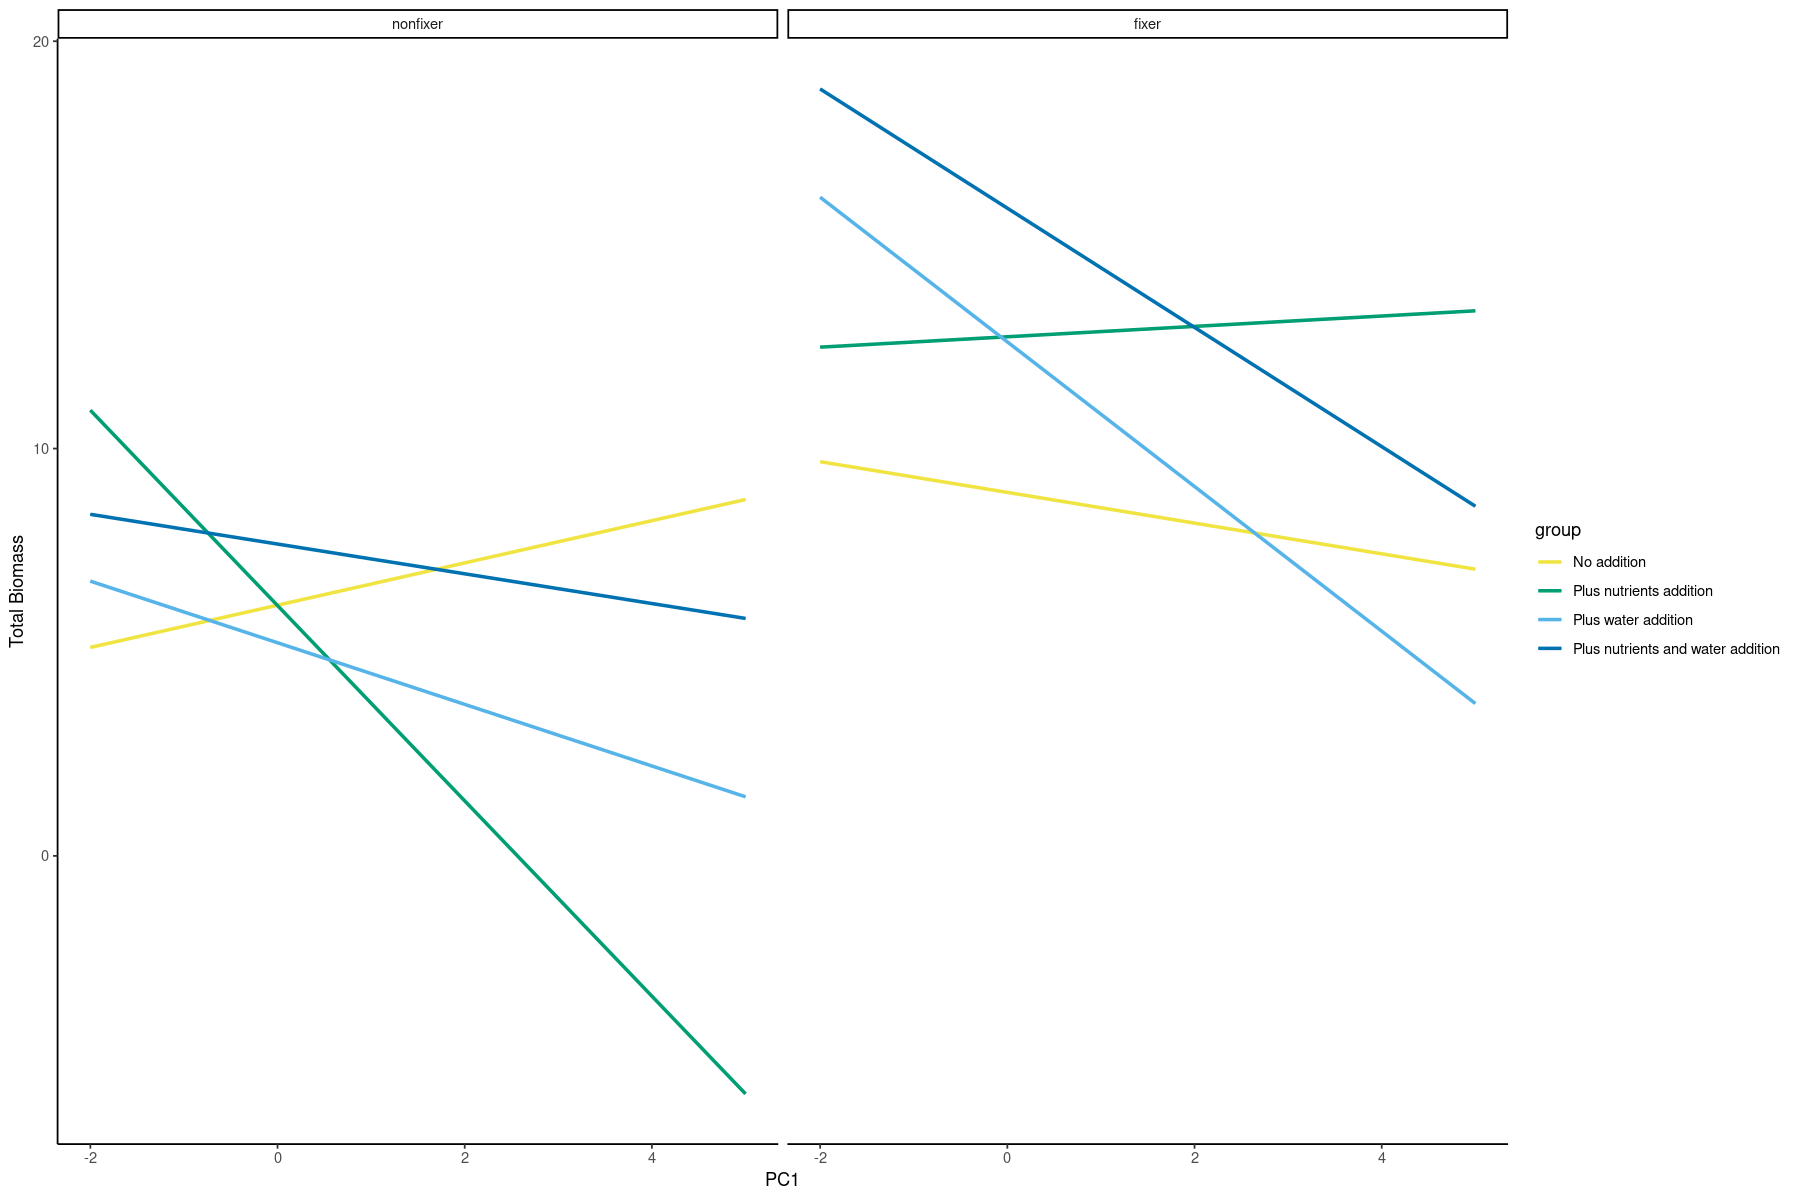

In [91]:
total_biomass_predict_p1 <- ggpredict(model_pc_total_biomass, terms = c("pc1","treatment", "nfixer"))

ggplot(total_biomass_predict_p1, aes(x, predicted, colour = group)) +

                        facet_grid( ~ facet) +
                        geom_line()+
                        ylab("Total Biomass")+

                        xlab("PC1")+
                        theme_classic()+
                        scale_color_manual(values= cbbPalette,
                                        labels=c("No addition", "Plus nutrients addition",
                                                  "Plus water addition",
                                                 "Plus nutrients and water addition")
                                        ) +
                      geom_line(size=1)

In [29]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "pc2")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -1.0442168| 0.3401669| 409.9857| -1.9217108| -0.1667228| -3.0697188| 0.0121974|
|no_additions - plus_water             | -1.8482033| 0.3784069| 410.0145| -2.8243409| -0.8720657| -4.8841688| 0.0000089|
|no_additions - plus_water_nutrients   | -0.8816113| 0.3473817| 412.7579| -1.7776919|  0.0144694| -2.5378745| 0.0557144|
|plus_nutrients - plus_water           | -0.8039865| 0.3292250| 409.9085| -1.6532554|  0.0452824| -2.4420580| 0.0709641|
|plus_nutrients - plus_water_nutrients |  0.1626055| 0.3367803| 413.1285| -0.7061252|  1.0313363|  0.4828238| 0.9628817|
|plus_water - plus_water_nutrients     |  0.9665921| 0.3289109| 409.8143|  0.1181326|  1.8150515|  2.9387655| 0.0182209|

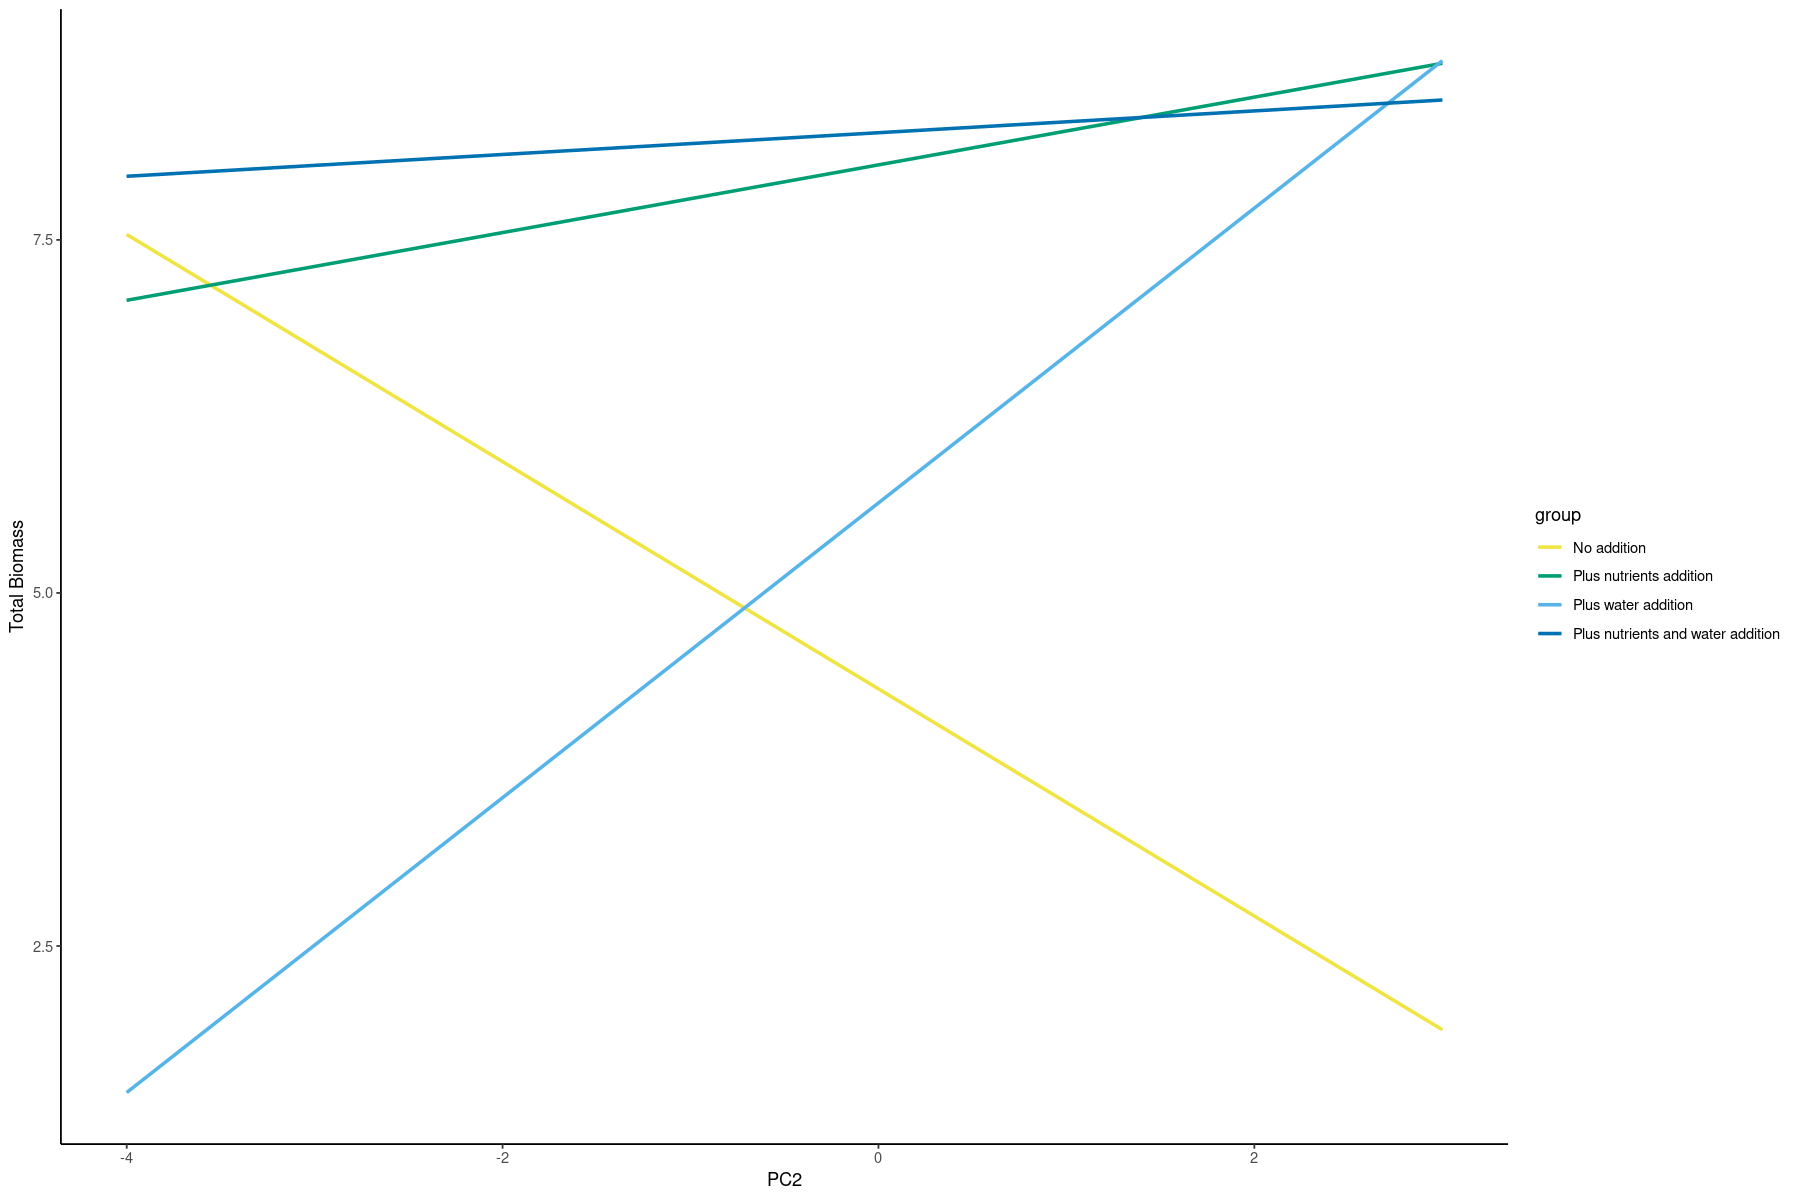

In [69]:
total_biomass_predict_p2 <- ggpredict(model_pc_total_biomass, terms = c("pc2","treatment"))

ggplot(total_biomass_predict_p2, aes(x, predicted, colour = group)) +

                      geom_line()+
                      ylab("Total Biomass")+

                      xlab("PC2")+
                      theme_classic()+
                      scale_color_manual(values= cbbPalette,
                                        labels=c("No addition", "Plus nutrients addition",
                                                  "Plus water addition",
                                                 "Plus nutrients and water addition")
                                        ) +
                      geom_line(size=1)

In [310]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "pc3")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.4076071| 0.3242590| 412.8023| -1.2440416|  0.4288274| -1.2570419| 0.5908644|
|no_additions - plus_water             |  0.4626414| 0.3239005| 409.6586| -0.3728946|  1.2981774|  1.4283440| 0.4823405|
|no_additions - plus_water_nutrients   | -0.5038761| 0.2305849| 412.3329| -1.0986786|  0.0909264| -2.1852086| 0.1290388|
|plus_nutrients - plus_water           |  0.8702485| 0.3459454| 409.8016| -0.0221534|  1.7626504|  2.5155659| 0.0590039|
|plus_nutrients - plus_water_nutrients | -0.0962690| 0.3074163| 409.4870| -0.8892836|  0.6967457| -0.3131551| 0.9893499|
|plus_water - plus_water_nutrients     | -0.9665175| 0.3173165| 408.9287| -1.7850752| -0.1479598| -3.0459104| 0.0131395|

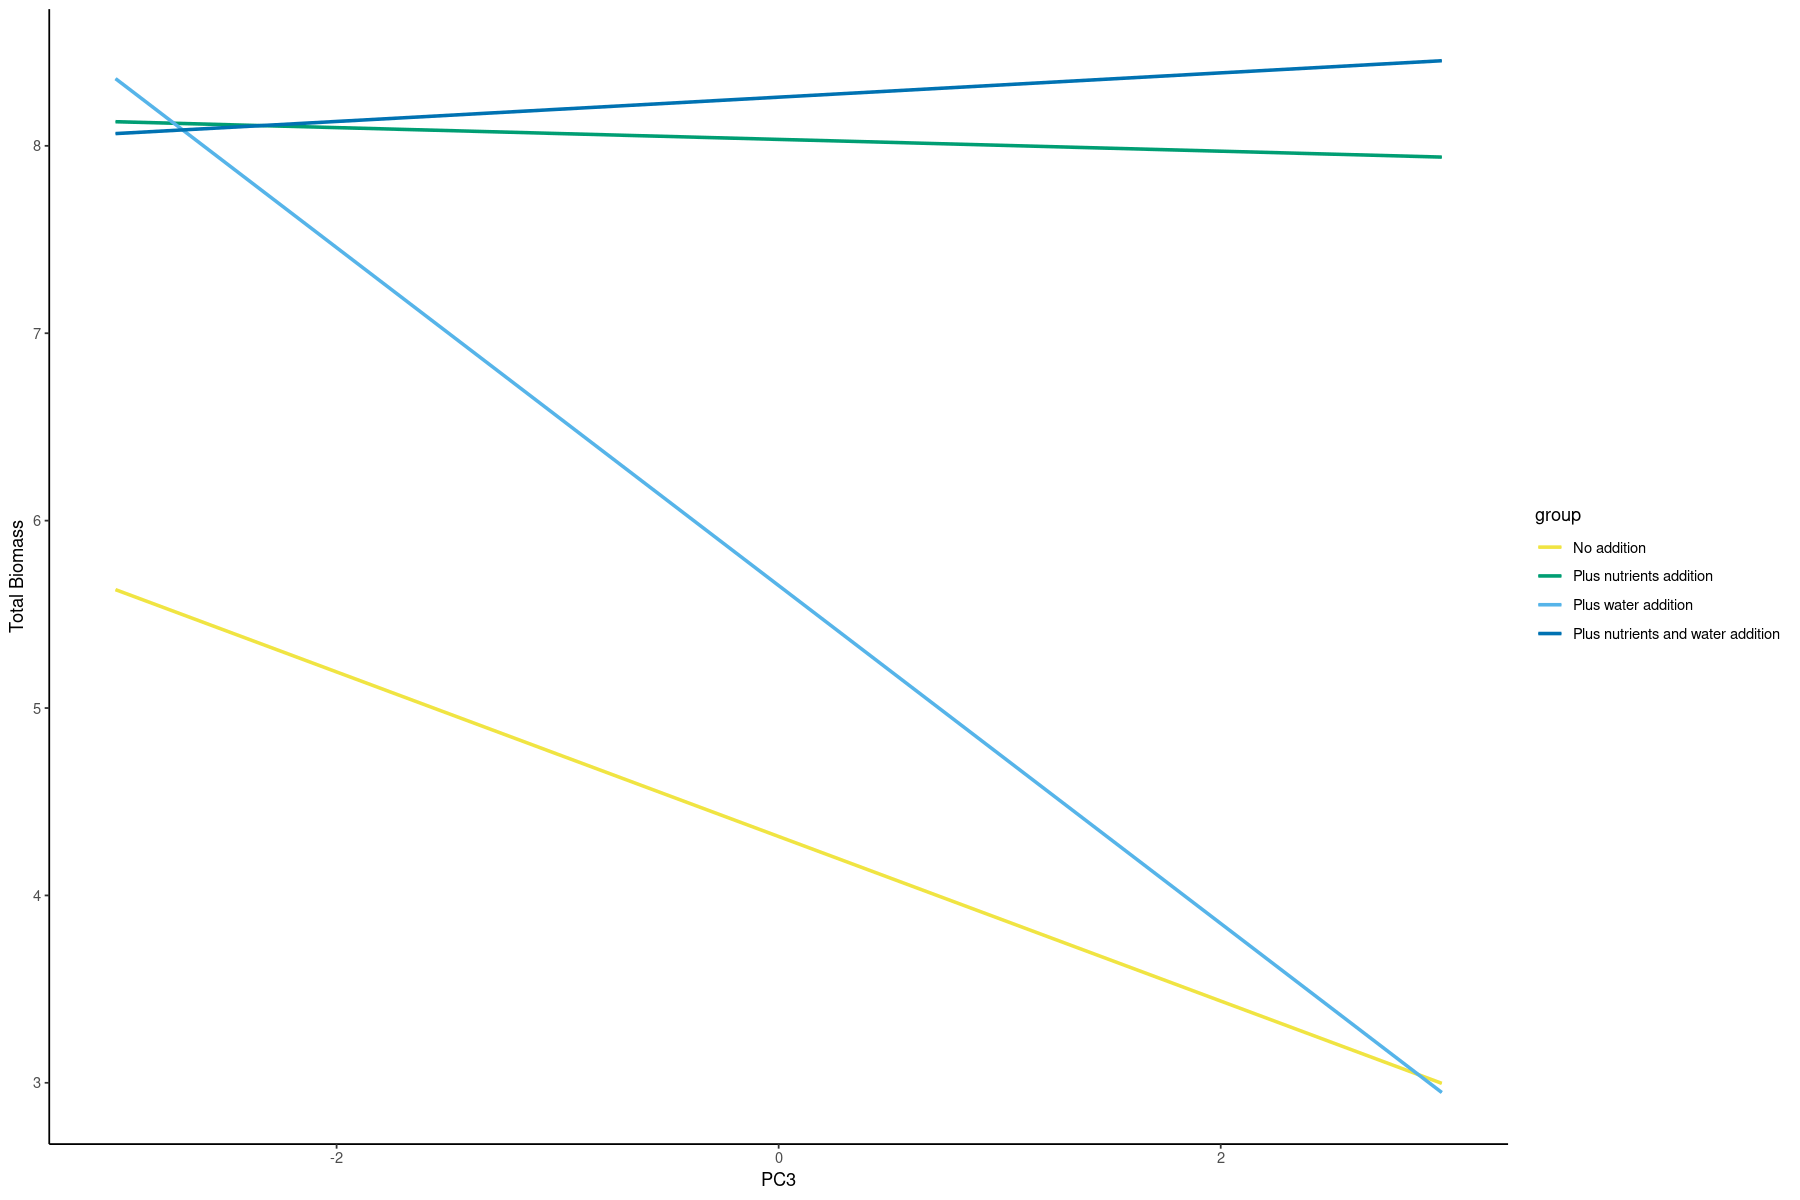

In [70]:
total_biomass_predict_p3 <- ggpredict(model_pc_total_biomass, terms = c("pc3","treatment"))
ggplot(total_biomass_predict_p3, aes(x, predicted, colour = group)) +

                      geom_line()+
                      ylab("Total Biomass")+

                      xlab("PC3")+
                      theme_classic()+
                      scale_color_manual(values= cbbPalette,
                                        labels=c("No addition", "Plus nutrients addition",
                                                  "Plus water addition",
                                                 "Plus nutrients and water addition")
                                        ) +
                      geom_line(size=1)

### RGR

In [312]:
emtrends(model_pc_rgr,
        pairwise ~ treatment,
        var = "pc1")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.0005710| 0.0001549| 411.5609| -0.0009706| -0.0001715| -3.6867104| 0.0014650|
|no_additions - plus_water             |  0.0000490| 0.0001458| 409.1475| -0.0003270|  0.0004250|  0.3360536| 0.9869116|
|no_additions - plus_water_nutrients   | -0.0003459| 0.0001358| 411.2728| -0.0006962|  0.0000043| -2.5478114| 0.0543088|
|plus_nutrients - plus_water           |  0.0006200| 0.0001660| 409.2034|  0.0001918|  0.0010482|  3.7353493| 0.0012215|
|plus_nutrients - plus_water_nutrients |  0.0002251| 0.0001537| 408.6244| -0.0001713|  0.0006216|  1.4647772| 0.4598425|
|plus_water - plus_water_nutrients     | -0.0003949| 0.0001249| 408.8213| -0.0007171| -0.0000727| -3.1615294| 0.0091130|

In [71]:
rgr_pc_1_predict <- ggpredict(model_pc_rgr, terms = c("pc1","treatment"))

In [313]:
emtrends(model_pc_rgr,
        pairwise ~ treatment,
        var = "pc2")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.0003234| 0.0002415| 408.8403| -0.0009465|  0.0002997| -1.3388317| 0.5386992|
|no_additions - plus_water             | -0.0011855| 0.0002687| 408.8378| -0.0018786| -0.0004924| -4.4122268| 0.0000771|
|no_additions - plus_water_nutrients   | -0.0003129| 0.0002468| 410.3417| -0.0009495|  0.0003238| -1.2676060| 0.5841219|
|plus_nutrients - plus_water           | -0.0008621| 0.0002338| 408.8352| -0.0014652| -0.0002591| -3.6877807| 0.0014603|
|plus_nutrients - plus_water_nutrients |  0.0000105| 0.0002393| 410.6949| -0.0006069|  0.0006279|  0.0439777| 0.9999694|
|plus_water - plus_water_nutrients     |  0.0008726| 0.0002336| 408.8027|  0.0002702|  0.0014751|  3.7363640| 0.0012169|

In [72]:
rgr_pc_2_predict <- ggpredict(model_pc_rgr, terms = c("pc2","treatment"))

In [314]:
emtrends(model_pc_rgr,
        pairwise ~ treatment,
        var = "pc3")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.0000863| 0.0002304| 410.4984| -0.0006807|  0.0005081| -0.3744854| 0.9820721|
|no_additions - plus_water             |  0.0010679| 0.0002300| 408.7208|  0.0004746|  0.0016612|  4.6434439| 0.0000274|
|no_additions - plus_water_nutrients   | -0.0001177| 0.0001638| 410.1843| -0.0005403|  0.0003050| -0.7181388| 0.8898629|
|plus_nutrients - plus_water           |  0.0011542| 0.0002457| 408.8107|  0.0005205|  0.0017879|  4.6985502| 0.0000212|
|plus_nutrients - plus_water_nutrients | -0.0000314| 0.0002183| 408.6407| -0.0005944|  0.0005317| -0.1437006| 0.9989405|
|plus_water - plus_water_nutrients     | -0.0011856| 0.0002253| 408.3854| -0.0017667| -0.0006044| -5.2627370| 0.0000014|

In [73]:
rgr_pc_3_predict <- ggpredict(model_pc_rgr, terms = c("pc3","treatment"))

### Root shoot ratio

In [37]:
emtrends(model_pc_root_shoot,
        pairwise ~ treatment,
        var = "pc1")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.0975724| 0.0313936| 410.5665| -0.1785549| -0.0165900| -3.1080338| 0.0108095|
|no_additions - plus_water             | -0.1186378| 0.0295352| 408.7824| -0.1948276| -0.0424480| -4.0168301| 0.0004071|
|no_additions - plus_water_nutrients   | -0.0818330| 0.0275175| 410.3318| -0.1528169| -0.0108492| -2.9738533| 0.0163903|
|plus_nutrients - plus_water           | -0.0210653| 0.0336344| 408.8247| -0.1078296|  0.0656990| -0.6263026| 0.9235896|
|plus_nutrients - plus_water_nutrients |  0.0157394| 0.0311398| 408.4211| -0.0645901|  0.0960689|  0.5054423| 0.9577672|
|plus_water - plus_water_nutrients     |  0.0368047| 0.0253099| 408.5569| -0.0284857|  0.1020951|  1.4541613| 0.4663658|

In [38]:
emtrends(model_pc_root_shoot,
        pairwise ~ treatment,
        var = "pc2")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.0178223| 0.0489414| 408.5642| -0.1440733| 0.1084287| -0.3641565| 0.9834678|
|no_additions - plus_water             |  0.0010968| 0.0544419| 408.5599| -0.1393433| 0.1415369|  0.0201462| 0.9999971|
|no_additions - plus_water_nutrients   | -0.0113950| 0.0500151| 409.6190| -0.1404144| 0.1176245| -0.2278302| 0.9958271|
|plus_nutrients - plus_water           |  0.0189191| 0.0473692| 408.5653| -0.1032760| 0.1411143|  0.3993976| 0.9784066|
|plus_nutrients - plus_water_nutrients |  0.0064274| 0.0485050| 409.8916| -0.1186962| 0.1315509|  0.1325095| 0.9991683|
|plus_water - plus_water_nutrients     | -0.0124918| 0.0473240| 408.5449| -0.1345705| 0.1095870| -0.2639623| 0.9935534|

In [39]:
emtrends(model_pc_root_shoot,
        pairwise ~ treatment,
        var = "pc3")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.1036118| 0.0467002| 409.7544| -0.2240797|  0.0168562| -2.2186598| 0.1198812|
|no_additions - plus_water             | -0.1469337| 0.0466006| 408.4872| -0.2671465| -0.0267210| -3.1530418| 0.0093659|
|no_additions - plus_water_nutrients   | -0.0041380| 0.0332030| 409.5249| -0.0897889|  0.0815130| -0.1246259| 0.9993076|
|plus_nutrients - plus_water           | -0.0433220| 0.0497761| 408.5524| -0.1717262|  0.0850823| -0.8703360| 0.8201935|
|plus_nutrients - plus_water_nutrients |  0.0994738| 0.0442272| 408.4322| -0.0146165|  0.2135641|  2.2491523| 0.1119745|
|plus_water - plus_water_nutrients     |  0.1427958| 0.0456458| 408.2578|  0.0250459|  0.2605456|  3.1283451| 0.0101370|